In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

import warnings
from tqdm.notebook import tqdm

from slide_preprocessing import *

In [3]:
data_dir = '/data/TRAIN/'
meta_df = generateMetaDF(data_dir)
meta_df.head()

/data/joni/PANDAChallenge/preprocessing/slide_preprocessing.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masks['image_id'] = masks.image_id.str.replace("_mask", "")


,slide_path,image_id,mask_path,data_provider,isup_grade,gleason_score
0,/data/TRAIN/train_images/0005f7aaab2800f6170c3...,0005f7aaab2800f6170c399693a96917,/data/TRAIN/train_label_masks/0005f7aaab2800f6...,karolinska,0,0+0
1,/data/TRAIN/train_images/000920ad0b612851f8e01...,000920ad0b612851f8e01bcc880d9b3d,/data/TRAIN/train_label_masks/000920ad0b612851...,karolinska,0,0+0
2,/data/TRAIN/train_images/0018ae58b01bdadc8e347...,0018ae58b01bdadc8e347995b69f99aa,/data/TRAIN/train_label_masks/0018ae58b01bdadc...,radboud,4,4+4
3,/data/TRAIN/train_images/001c62abd11fa4b57bf7a...,001c62abd11fa4b57bf7a6c603a11bb9,/data/TRAIN/train_label_masks/001c62abd11fa4b5...,karolinska,4,4+4
4,/data/TRAIN/train_images/001d865e65ef5d2579c19...,001d865e65ef5d2579c190a0e0350d8f,/data/TRAIN/train_label_masks/001d865e65ef5d25...,karolinska,0,0+0


In [4]:
print(len(meta_df))
meta_df = meta_df[meta_df.mask_path.notnull()]
print(len(meta_df))

10616
10516


In [5]:
extract_tile_size = 299
level = 1
mosaic_grid = (5,5)
output_tile_size = 299
stack = True
tissue_th = (0.2,0.7)
seed=123

In [6]:
meta_df[meta_df['image_id'] == "2268c3174c1c0890af7ae1bae4c8cd74"]

,slide_path,image_id,mask_path,data_provider,isup_grade,gleason_score
1348,/data/TRAIN/train_images/2268c3174c1c0890af7ae...,2268c3174c1c0890af7ae1bae4c8cd74,/data/TRAIN/train_label_masks/2268c3174c1c0890...,radboud,5,4+5


In [7]:
meta_df.head()

,slide_path,image_id,mask_path,data_provider,isup_grade,gleason_score
0,/data/TRAIN/train_images/0005f7aaab2800f6170c3...,0005f7aaab2800f6170c399693a96917,/data/TRAIN/train_label_masks/0005f7aaab2800f6...,karolinska,0,0+0
1,/data/TRAIN/train_images/000920ad0b612851f8e01...,000920ad0b612851f8e01bcc880d9b3d,/data/TRAIN/train_label_masks/000920ad0b612851...,karolinska,0,0+0
2,/data/TRAIN/train_images/0018ae58b01bdadc8e347...,0018ae58b01bdadc8e347995b69f99aa,/data/TRAIN/train_label_masks/0018ae58b01bdadc...,radboud,4,4+4
3,/data/TRAIN/train_images/001c62abd11fa4b57bf7a...,001c62abd11fa4b57bf7a6c603a11bb9,/data/TRAIN/train_label_masks/001c62abd11fa4b5...,karolinska,4,4+4
4,/data/TRAIN/train_images/001d865e65ef5d2579c19...,001d865e65ef5d2579c190a0e0350d8f,/data/TRAIN/train_label_masks/001d865e65ef5d25...,karolinska,0,0+0


In [10]:
%%time
## Read a random slide
#row = np.random.randint(len(meta_df))
row = 1348

slide_fn = meta_df.slide_path.loc[row]
mask_fn = meta_df.mask_path.loc[row]
data_provider = meta_df.data_provider.loc[row]
slide = Slide(slide_fn, level=level, 
              tile_size=extract_tile_size, 
              mask_fn=mask_fn, 
              data_provider=data_provider)

tiles = slide.getTiles(mosaic_grid=mosaic_grid,
                       stack=True,
                       sampling_method='skeleton',
                       output_tile_size=output_tile_size,
                       tissue_th=tissue_th, seed=seed)
if mask_fn!=None and data_provider!=None:
    cats = slide.getTilesCancerStatus(mosaic_grid=mosaic_grid, stack=True)
else:
    cats = None

CPU times: user 1.38 s, sys: 177 ms, total: 1.56 s
Wall time: 587 ms


/data/joni/PANDAChallenge/preprocessing/slide_preprocessing.py:393: UserWarning: Could not find enough unique tiles for the slide(tiles: 19/25, slide: /data/TRAIN/train_images/2268c3174c1c0890af7ae1bae4c8cd74.tiff
  "(tiles: %s/%s, slide: %s" %(len(self.tile_coords), m*n, self.slide_fn))


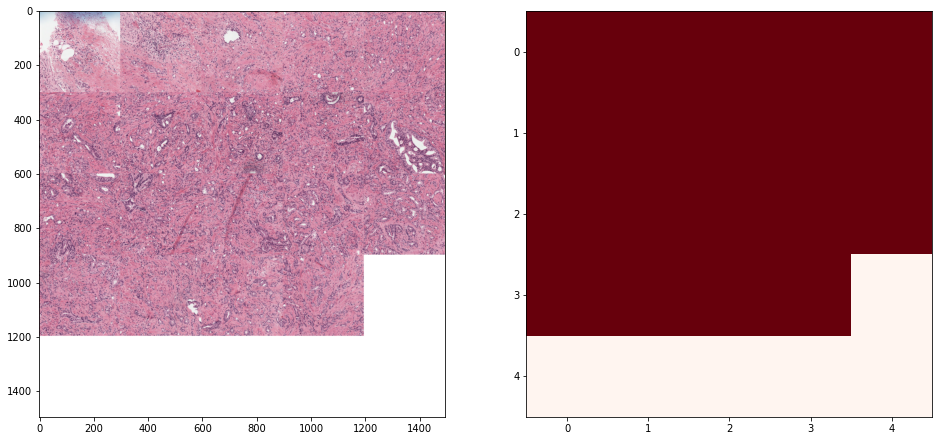

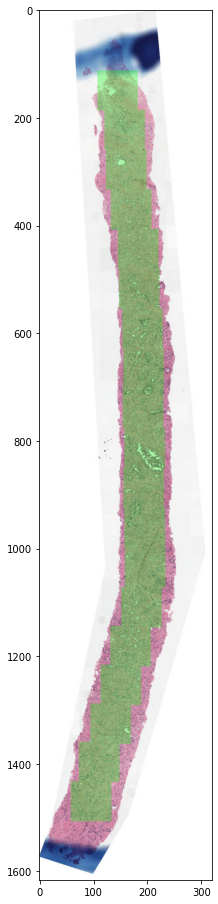

In [11]:
## Visualize mosaic
plt.figure(figsize=(16,8))
if mask_fn!=None and data_provider!=None:
    plt.subplot(121)
    plt.imshow(tiles)
    plt.subplot(122)
    plt.imshow(cats*125, cmap='Reds')
    
else:
    plt.imshow(tiles)
plt.show()

## Mosaic coverage
slide.visualizeCoverage()

In [15]:
import zipfile
tile_size = 299
mosaic_grid = (5,5)
level=1
sz = 299
N = np.multiply(*mosaic_grid)
OUT_TRAIN = os.path.join('../../','train_{4}_{3}_{0}_{1}x{2}-skeleton-mask'.format(sz, *mosaic_grid, tile_size, level))
!mkdir {OUT_TRAIN}
OUT_TRAIN

'../../train_1_299_299_5x5-skeleton-mask'

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
from multiprocessing import Pool
n_proc = 30

In [18]:
def saveImagesMultiprocessing(idx):
    x_tot,x2_tot = [],[]
    num_tiles = 0
    row = meta_df.iloc[idx]
    slide_id = row.image_id
    slide_fn =row.slide_path
    mask_fn = row.mask_path
    data_provider = row.data_provider
    try:
        slide = Slide(slide_fn, level=level, 
              tile_size=tile_size, 
              mask_fn=mask_fn, 
              data_provider=data_provider)
        
        tiles = slide.getTiles(mosaic_grid=mosaic_grid,
                       stack=False,
                       sampling_method='skeleton',
                       output_tile_size=sz,
                       tissue_th=tissue_th, seed=seed)
        if mask_fn!=None and data_provider!=None:
            cats = slide.getTilesCancerStatus(mosaic_grid=mosaic_grid, stack=False)
        else:
            cats = None
            
        num_tiles = len(slide.tile_coords)
    except Exception as e:
        return (x_tot, x2_tot, slide_id, num_tiles, str(e))
    
    for idx, t in enumerate(tiles):
        img = t
        x_tot.append((img/255.0).reshape(-1,3).mean(0))
        x2_tot.append(((img/255.0)**2).reshape(-1,3).mean(0)) 
        #if read with PIL RGB turns into BGR
        cv2.imwrite(os.path.join(OUT_TRAIN,f'{slide_id}_{idx}.png'), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    # write categories
    cat_str = ("\n").join([f"{cat}" for cat in cats])
    with open(os.path.join(OUT_TRAIN,f'{slide_id}_mask.txt'), "w") as text_file:
        text_file.write(cat_str)
    return (x_tot, x2_tot, slide_id, num_tiles, "")

In [19]:
x_tot,x2_tot = [],[]
failed_ids = []
all_ids = []
all_num_tiles = []
all_errors = []
with Pool(processes=n_proc) as pool:
    tasks = range(len(meta_df))
    for (x_tot_one, x2_tot_one, slide_id, num_tiles, error) in tqdm(pool.imap_unordered(saveImagesMultiprocessing, tasks), total=len(tasks)):
        if len(x_tot_one) == 0:
            failed_ids.append(slide_id)
        x_tot += x_tot_one
        x2_tot += x2_tot_one
        all_ids.append(slide_id)
        all_num_tiles.append(num_tiles/N)
        all_errors.append(error)

In [20]:
df_tile_stats = pd.DataFrame({'image_id':all_ids, 
                              'num_tiles':all_num_tiles,
                              'error':all_errors})
df_tile_stats.head()

,image_id,num_tiles,error
0,006f6aa35a78965c92fffd1fbd53a058,0.16,
1,0068d4c7529e34fd4c9da863ce01a161,0.28,
2,003a91841da04a5a31f808fb5c21538a,0.28,
3,000920ad0b612851f8e01bcc880d9b3d,0.36,
4,0018ae58b01bdadc8e347995b69f99aa,0.84,


In [21]:
df_failed = df_tile_stats[df_tile_stats.error != ""]
df_failed

,image_id,num_tiles,error
2209,3790f55cad63053e956fb73027179707,0.0,division by zero


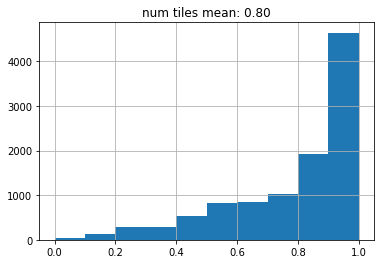

In [22]:
f,ax = plt.subplots(1,1)
ax.set_title("num tiles mean: {0:.2f}".format(
    np.array(df_tile_stats.num_tiles.values).mean()))
df_tile_stats.num_tiles.hist()


In [23]:
#image stats
img_avr =  np.array(x_tot).mean(0)
img_std =  np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
print('mean:',img_avr, ', std:', np.sqrt(img_std))

mean: [0.85807967 0.70262275 0.80347739] , std: [0.39635435 0.52671275 0.42666426]


In [24]:
print('mean inverted:',1-img_avr, ', std:', np.sqrt(img_std))

mean inverted: [0.14192033 0.29737725 0.19652261] , std: [0.39635435 0.52671275 0.42666426]
